## Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

## Load and Preprocess CIFAR-10 Dataset

In [2]:
# Define image transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check dataset size
print(f"Training samples: {len(train_dataset)} | Testing samples: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000 | Testing samples: 10000


In [3]:
# Define the neural network with 20 hidden layers

class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.hidden_layers = nn.ModuleList()

        # Input Layer (3072 32x32x3)
        self.hidden_layers.append(nn.Linear(32*32*3, 100))

        # Hidden layers (20 layers of 100 neurons)
        for _ in range(19):
            self.hidden_layers.append(nn.Linear(100,100))

        # Output layer (10 classes)
        self.output_layer = nn.Linear(100,10)

        # Apply He Initialization
        self.init_weights()
    
    def init_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)
        
        nn.init.xavier_uniform_(self.output_layer.weight) # Xavier for output weight

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten input image
        for layer in self.hidden_layers:
            x = layer(x)
            x = nn.ELU()(x) # Using ELU activation
        x = self.output_layer(x)
        return x

#crete model instance
model = DeepNN()
print(model)

DeepNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1-19): 19 x Linear(in_features=100, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)


## Train the Model with Nadam and Early Stopping

Epoch 1/30, Train Loss: 1.6767, Test Loss: 1.7643
Epoch 2/30, Train Loss: 1.5603, Test Loss: 1.6427
Epoch 3/30, Train Loss: 1.4846, Test Loss: 1.5983
Epoch 4/30, Train Loss: 1.4230, Test Loss: 1.6164
Epoch 5/30, Train Loss: 1.3723, Test Loss: 1.4829
Epoch 6/30, Train Loss: 1.3307, Test Loss: 1.5222
Epoch 7/30, Train Loss: 1.2848, Test Loss: 1.4925
Epoch 8/30, Train Loss: 1.2545, Test Loss: 1.5052
Epoch 9/30, Train Loss: 1.2193, Test Loss: 1.5750
Epoch 10/30, Train Loss: 1.0896, Test Loss: 1.4391
Epoch 11/30, Train Loss: 1.0377, Test Loss: 1.4605
Epoch 12/30, Train Loss: 1.0000, Test Loss: 1.4860
Epoch 13/30, Train Loss: 0.9693, Test Loss: 1.4831
Epoch 14/30, Train Loss: 0.9328, Test Loss: 1.5403
Epoch 15/30, Train Loss: 0.8335, Test Loss: 1.5643
Epoch 16/30, Train Loss: 0.7938, Test Loss: 1.5870
Epoch 17/30, Train Loss: 0.7637, Test Loss: 1.6664
Epoch 18/30, Train Loss: 0.8962, Test Loss: 1.5885
Epoch 19/30, Train Loss: 0.7680, Test Loss: 1.6494
Epoch 20/30, Train Loss: 0.7906, Test Lo

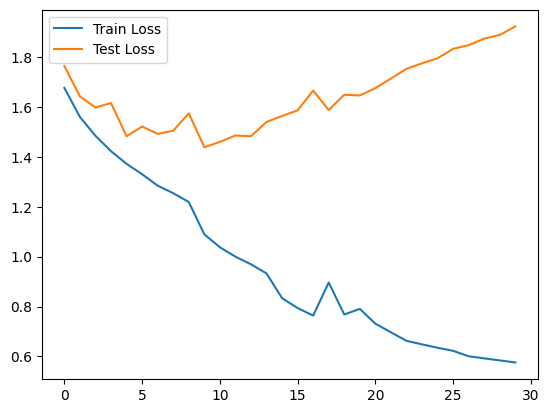

In [6]:
# Define loss function and optimiser

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001) # Nadam optimizer

# Early stopping setup
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
num_epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Store training loss
    train_losses.append(running_loss / len(train_loader))

    # Validate on test data 
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # store test loss
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Early stopping based on validation loss
    scheduler.step(test_losses[-1])

# Plot learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

## Add Batch Normalization

In [10]:
class DeepNN_BN(nn.Module):
    def __init__(self):
        super(DeepNN_BN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        self.hidden_layers.append(nn.Linear(32*32*3, 100))
        self.hidden_layers.append(nn.BatchNorm1d(100))  # BatchNorm

        for _ in range(19):
            self.hidden_layers.append(nn.Linear(100, 100))
            self.hidden_layers.append(nn.BatchNorm1d(100))  # BatchNorm
        
        self.output_layer = nn.Linear(100, 10)
        self.init_weights()

    def init_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)

        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.hidden_layers:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                x = nn.ELU()(x)
        x = self.output_layer(x)
        return x

model_bn = DeepNN_BN()

/Users/caephas/Downloads/School-Projects/ReinforcementLearning/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30, Train Loss: 3.0545, Test Loss: 2.9586
Epoch 2/30, Train Loss: 3.0639, Test Loss: 2.9679
Epoch 3/30, Train Loss: 3.0614, Test Loss: 2.9487
Epoch 4/30, Train Loss: 3.0608, Test Loss: 2.9571
Epoch 5/30, Train Loss: 3.0561, Test Loss: 2.9447
Epoch 6/30, Train Loss: 3.0525, Test Loss: 2.9628
Epoch 7/30, Train Loss: 3.0597, Test Loss: 2.9419
Epoch 8/30, Train Loss: 3.0634, Test Loss: 2.9661
Epoch 9/30, Train Loss: 3.0541, Test Loss: 2.9616
Epoch 10/30, Train Loss: 3.0605, Test Loss: 2.9598
Epoch 11/30, Train Loss: 3.0546, Test Loss: 2.9597
Epoch 12/30, Train Loss: 3.0567, Test Loss: 2.9528
Epoch 13/30, Train Loss: 3.0546, Test Loss: 2.9579
Epoch 14/30, Train Loss: 3.0592, Test Loss: 2.9598
Epoch 15/30, Train Loss: 3.0627, Test Loss: 2.9549
Epoch 16/30, Train Loss: 3.0619, Test Loss: 2.9551
Epoch 17/30, Train Loss: 3.0595, Test Loss: 2.9530
Epoch 18/30, Train Loss: 3.0565, Test Loss: 2.9437
Epoch 19/30, Train Loss: 3.0583, Test Loss: 2.9566
Epoch 20/30, Train Loss: 3.0515, Test Lo

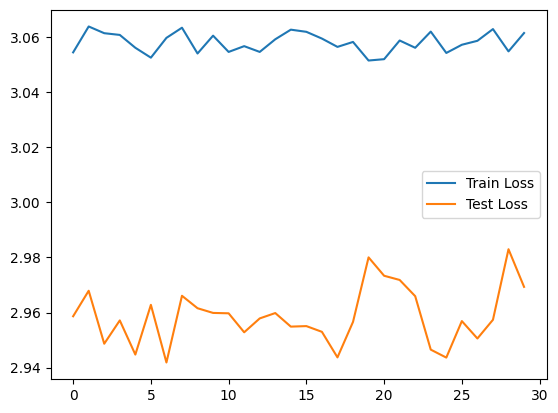

In [11]:
# Define loss function and optimiser

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001) # Nadam optimizer

# Early stopping setup
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
num_epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_bn.to(device)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_bn.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Store training loss
    train_losses.append(running_loss / len(train_loader))

    # Validate on test data 
    model_bn.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_bn(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # store test loss
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Early stopping based on validation loss
    scheduler.step(test_losses[-1])

# Plot learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

## Replace Batch Normalization with SELU

In [12]:
class DeepNN_SELU(nn.Module):
    def __init__(self):
        super(DeepNN_SELU, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        self.hidden_layers.append(nn.Linear(32*32*3, 100))

        for _ in range(19):
            self.hidden_layers.append(nn.Linear(100, 100))
        
        self.output_layer = nn.Linear(100, 10)

        # Use LeCun Initialization for SELU
        self.init_weights()

    def init_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=1.0 / torch.sqrt(torch.tensor(layer.in_features, dtype=torch.float)))
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.hidden_layers:
            x = layer(x)
            x = nn.SELU()(x)  # Using SELU activation
        x = self.output_layer(x)
        return x

model_selu = DeepNN_SELU()

Epoch 1/30, Train Loss: 2.4077, Test Loss: 2.3986
Epoch 2/30, Train Loss: 2.4080, Test Loss: 2.3986
Epoch 3/30, Train Loss: 2.4079, Test Loss: 2.3986
Epoch 4/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 5/30, Train Loss: 2.4080, Test Loss: 2.3986
Epoch 6/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 7/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 8/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 9/30, Train Loss: 2.4080, Test Loss: 2.3986
Epoch 10/30, Train Loss: 2.4079, Test Loss: 2.3986
Epoch 11/30, Train Loss: 2.4079, Test Loss: 2.3986
Epoch 12/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 13/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 14/30, Train Loss: 2.4079, Test Loss: 2.3986
Epoch 15/30, Train Loss: 2.4081, Test Loss: 2.3986
Epoch 16/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 17/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 18/30, Train Loss: 2.4081, Test Loss: 2.3986
Epoch 19/30, Train Loss: 2.4078, Test Loss: 2.3986
Epoch 20/30, Train Loss: 2.4078, Test Lo

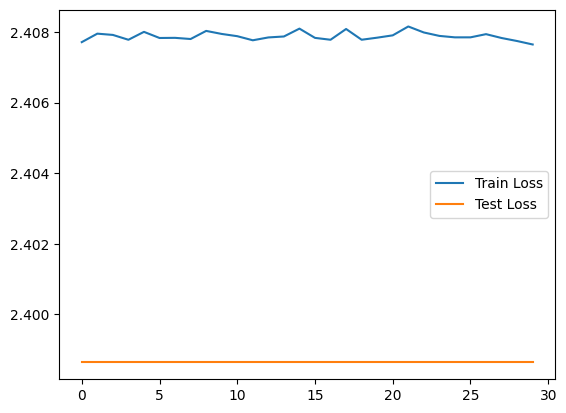

In [13]:
# Define loss function and optimiser

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001) # Nadam optimizer

# Early stopping setup
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
num_epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_selu.to(device)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_selu.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_selu(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Store training loss
    train_losses.append(running_loss / len(train_loader))

    # Validate on test data 
    model_selu.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_selu(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # store test loss
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Early stopping based on validation loss
    scheduler.step(test_losses[-1])

# Plot learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

## USe Alpha Dropout & MC Droput

In [18]:
# Define the DNN with Alpha Dropout
class DeepNN_AlphaDropout(nn.Module):
    def __init__(self):
        super(DeepNN_AlphaDropout, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        # Input layer
        self.hidden_layers.append(nn.Linear(32*32*3, 100))

        # Hidden layers with SELU activation
        for _ in range(19):
            self.hidden_layers.append(nn.Linear(100, 100))
        
        # Output layer
        self.output_layer = nn.Linear(100, 10)

        # Initialize weights using LeCun Normal (recommended for SELU)
        self.init_weights()

    def init_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=1.0 / torch.sqrt(torch.tensor(layer.in_features, dtype=torch.float)))
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input image
        
        for layer in self.hidden_layers:
            x = layer(x)
            x = nn.SELU()(x)  # SELU activation
            x = nn.AlphaDropout(0.1)(x)  # Apply Alpha Dropout after SELU
        
        x = self.output_layer(x)  # Output layer
        return x

# Create model instance
model_AlphaDrop = DeepNN_AlphaDropout()


Epoch 1/30, Train Loss: 2.0880, Test Loss: 2.0039
Epoch 2/30, Train Loss: 1.9586, Test Loss: 1.9398
Epoch 3/30, Train Loss: 1.9058, Test Loss: 1.9313
Epoch 4/30, Train Loss: 1.8615, Test Loss: 1.8835
Epoch 5/30, Train Loss: 1.8200, Test Loss: 1.8211
Epoch 6/30, Train Loss: 1.7816, Test Loss: 1.7645
Epoch 7/30, Train Loss: 1.7658, Test Loss: 1.7423
Epoch 8/30, Train Loss: 1.7599, Test Loss: 1.7634
Epoch 9/30, Train Loss: 1.7367, Test Loss: 1.7752
Epoch 10/30, Train Loss: 1.7278, Test Loss: 1.7653
Epoch 11/30, Train Loss: 1.7156, Test Loss: 1.7534
Epoch 12/30, Train Loss: 1.6684, Test Loss: 1.6799
Epoch 13/30, Train Loss: 1.6429, Test Loss: 1.6683
Epoch 14/30, Train Loss: 1.6298, Test Loss: 1.6678
Epoch 15/30, Train Loss: 1.6152, Test Loss: 1.6563
Epoch 16/30, Train Loss: 1.6189, Test Loss: 1.6568
Epoch 17/30, Train Loss: 1.6066, Test Loss: 1.6326
Epoch 18/30, Train Loss: 1.5951, Test Loss: 1.6417
Epoch 19/30, Train Loss: 1.5891, Test Loss: 1.6381
Epoch 20/30, Train Loss: 1.5763, Test Lo

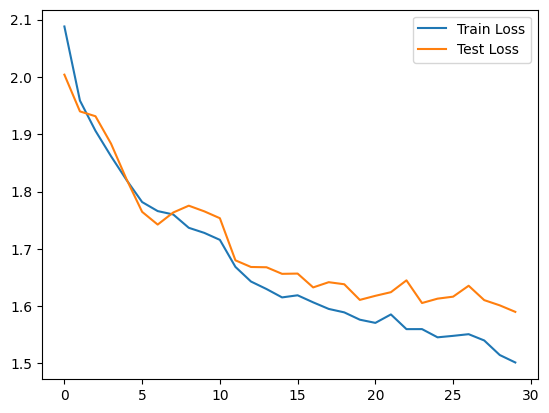

In [19]:
 #Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model_AlphaDrop.parameters(), lr=0.001)  # Corrected optimizer reference

# Early stopping setup
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AlphaDrop.to(device)

# Training loop
num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_AlphaDrop.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_AlphaDrop(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Store training loss
    train_losses.append(running_loss / len(train_loader))

    # Validate on test data 
    model_AlphaDrop.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_AlphaDrop(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # Store test loss
    test_losses.append(test_loss / len(test_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Early stopping based on validation loss
    scheduler.step(test_losses[-1])

# Plot learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()